# aim2 workshop - From models to complete solutions using OpenVINO 
[![aim2](./assets/aim2.png)](https://www.youtube.com/watch?v=a6bwjYjuBEg)

### Luca Ruzzola, Machine Learning Engineer @ aim2.io

### What is computer vision
*"**Computer vision** is concerned with the automatic extraction, analysis and understanding of useful information from a single image or a sequence of images. It involves the development of a theoretical and algorithmic basis to achieve automatic visual understanding."*

### What is deep learning
*"**Deep Learning** is a class of machine learning algorithms that use a cascade of multiple layers of nonlinear processing units for feature extraction and transformation to learn multiple levels of representations that correspond to different levels of abstraction; the levels form a hierarchy of concepts."*

*"**Machine Learning** is the discipline that provides systems the ability to automatically learn and improve from experience without being explicitly programmed."*

*"**AI** is the discipline dealing with the designing and building of intelligent agents that receive percepts from the environment and take actions that affect that environment."*

![Deep learning](./assets/deep_learning.png)

### What is a CNN
A **CNN** is a neural network that uses kernel convolution instead of matrix multiplication in one or more of its layers.
![Convolution](./assets/convolution.gif)

![Application of a blur filter](./assets/filterd_image.png)

![Application of an edge detection filter](./assets/cameraman.png)

## Let's get our hands dirty!

# Environment setup

Please clone this repository: https://github.com/lucaruzzola/aaeon_workshop

*git clone https://github.com/lucaruzzola/aaeon_workshop*

If you don't have git installed you can install it executing this command in a terminal:
*sudo apt-get install git*

Create the Anaconda environment as such: *conda env create -f workshopenv.yml*

If you don't have Anaconda installed already you can download it from: https://repo.anaconda.com/archive/Anaconda3-2018.12-Linux-x86_64.sh

To test that everything is working please type in a terminal: 

*source activate workshop*

*source /opt/intel/computer_vision_sdk/bin/setupvars.sh*

*python blur.py*

If everything is working as expected you should see the live video from your camera with blurred faces.

You can then quit the demo by pressing "q" and start the notebook for this session typing in the same terminal:

*python -m jupyter notebook*

In [1]:
import cv2
import os
import openvino
import copy
from openvino.inference_engine import IEPlugin, IENetwork
from utils import SyRegion, SyFrame, Location, draw_bounding_box
import matplotlib.pyplot as plt
%matplotlib inline

# Acquire images from you camera

In [2]:
#Try to use opencv's VideoCapture class and plt.show to capture and display an image from your camera

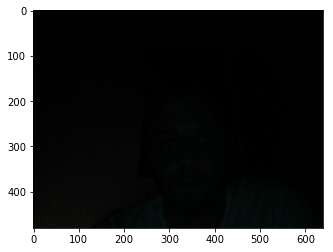

In [3]:
cap = cv2.VideoCapture(0)
try:
    ret, img = cap.read()
    plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
    plt.show
except Exception as e:
    print(e)
cap.release()

# Face detection

Traditional techniques, like Viola-Jones used custom-engineered features, and work quite well without the need to train them, however they are quite brittle and make somewhat strict assumptions.
Modern techniques like MobileNetSSD are more precise and particularly more resilient, they can account for more variation in a face and its position in the image.

MobileNetSSD is a very popular CNN architecture for general object detection, especially used on low power devices, and as every deep learning model requires quite a bit of expertise to train and deploy.
However thanks to OpenVINO and its model zoo it's nowadays possible to use it just like any other library you encounter in you daily workflow.

You can simply load the model and use to get the bounding boxes of every face in an image, however there is still quite a bit of code that you need to write to be able to use it effectively and even more easily, and we will later see how easy this can get when you have the necessary tools in place, to be able to go from thinking about a single model, to thinking about a complete AI solution.

In [4]:
from models import FaceDetector

face_xml="./assets/face_detection/FP32/fd.xml"
face_bin="./assets/face_detection/FP32/fd.bin"

face_detector = FaceDetector(model_xml=face_xml,\
                             model_bin=face_bin,\
                             device="CPU",\
                             confidence_threshold=0.8,\
                             cpu_extension="/opt/intel/computer_vision_sdk/deployment_tools/inference_engine/lib/ubuntu_16.04/intel64/libcpu_extension_sse4.so")

In [5]:
#Use the utilities we provided to detect all faces in a image and to display a box around them
#In particular, take a loook at draw_bounding_box, plt.imshow, and the face_detector class
#Before feeding the frame to the detector please wrap it using SyFrame e.g. wrapped_image = SyFrame(img)

#Bonus: try to change the confidence threshold in the previous block and see the different results you get

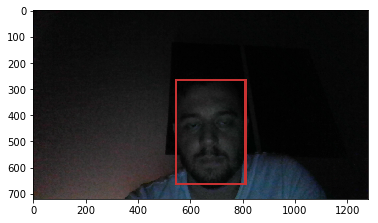

In [6]:
cap = cv2.VideoCapture(0)
cap.set(cv2.CAP_PROP_FRAME_WIDTH, 1280)
cap.set(cv2.CAP_PROP_FRAME_HEIGHT, 720)

ret, img = cap.read()
detected_faces=face_detector.detect(SyFrame(img))

try:
    for face in detected_faces:
        draw_bounding_box(face,img,color=(50,50,200),thickness=8)
    plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
    plt.show
except Exception as e:
    print(e)
    
cap.release()

# Blur the face
We are now going to use OpenCV to blur the faces that we have just detected, in order to reproduce the same result that you saw before and therefore to build a privacy-preserving system.

In [7]:
#Now that you are able to get all faces from a given image, let's blur them
#To do this, take a look at the cv2.blur function
#You can then display a modified image where you changed the original pixels with blurried ones
#To change the pixels to the blurried ones you can do something like this
# img[sq_loc.y:sq_loc.y+blur_face.shape[0], sq_loc.x:sq_loc.x+blur_face.shape[1]] = blur_face

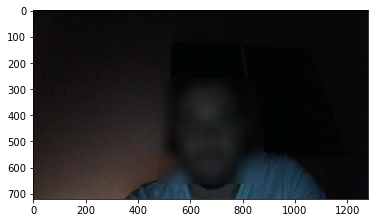

In [8]:
cap = cv2.VideoCapture(0)
cap.set(cv2.CAP_PROP_FRAME_WIDTH, 1280)
cap.set(cv2.CAP_PROP_FRAME_HEIGHT, 720)

ret, img = cap.read()
detected_faces=face_detector.detect(SyFrame(img))
try:
    for face in detected_faces:
        sq_loc = face.get_square_location()
        blur_face = face.get_square_frame_region().frame
        blur_face = cv2.blur(blur_face,(55,55))

        img[sq_loc.y:sq_loc.y+blur_face.shape[0], sq_loc.x:sq_loc.x+blur_face.shape[1]] = blur_face

    plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
    plt.show
except Exception as e:
    print(e)
cap.release()

# Emotion recognition
Now we are going to add emotion recognition to our system, so that we can show an emoji in real time, matching people's expressions, instead of just blurring.

We are again going to use a pre-trained CNN that has been trained for this very specific task, to be able to distinguish between 5 different expressions: neutral, happy, sad, surprised, angry.

The output is going to be something like this:
![Emoji result](./assets/emoji_result.png)

In [9]:
#Finally, let's display an emoji with the current expression on people faces instead of a simple blur
#Take a look at the emoji_overlay utility, and at the emotion_classifier model

In [10]:
from models import EmotionClassifier
from utils import load_emojis 
from utils import emoji_overlay

emotion_classifier = EmotionClassifier(model_xml="./assets/emotion_recognition/FP32/em.xml",\
                                       model_bin="./assets/emotion_recognition/FP32/em.bin",\
                                       device="CPU",\
                                       cpu_extension="/opt/intel/computer_vision_sdk/deployment_tools/inference_engine/lib/ubuntu_16.04/intel64/libcpu_extension_sse4.so",\
                                       emotion_label_list=["neutral", "happy", "sad", "surprise", "anger"])

emojis = load_emojis("./assets/emojis/")

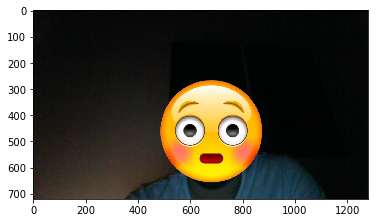

In [11]:
cap = cv2.VideoCapture(0)
cap.set(cv2.CAP_PROP_FRAME_WIDTH, 1280)
cap.set(cv2.CAP_PROP_FRAME_HEIGHT, 720)

ret, img = cap.read()
detected_faces=face_detector.detect(SyFrame(img))

try:
    for face in detected_faces:
        emotion = emotion_classifier.predict(face.get_square_frame_region().frame)
        emoji_overlay(emojis[emotion], img, face.location)

    plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
    plt.show
except Exception as e:
    print(e)
cap.release()